# Multimodal Report Generation (from a Slide Deck)

<a href="https://colab.research.google.com/github/run-llama/llama_cloud_services/blob/main/examples/parse/multimodal/multimodal_report_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this cookbook we show you how to build a multimodal report generator. The pipeline parses a slide deck and stores both text and image chunks. It generates a detailed response that contains interleaving text and images.

**NOTE**: This pipeline operates over the entire document and does not do retrieval, in order to retrieve the full context. You can of course explore adding a higher-level retrieval layer where you retrieve the relevant document(s) first before feeding to a multimodal model.

Status:
| Last Executed | Version | State      |
|---------------|---------|------------|
| Aug-20-2025   | 0.6.61  | Maintained |

## Setup

In [ ]:
%pip install llama-cloud-services "llama-index>=0.13.0<0.14.0"

In [ ]:
import os

os.environ["LLAMA_CLOUD_API_KEY"] = "llx-..."
os.environ["OPENAI_API_KEY"] = "sk-..."

### (Optional) Setup Observability

We setup an integration with LlamaTrace (integration with Arize).

If you haven't already done so, make sure to create an account here: https://llamatrace.com/login. Then create an API key and put it in the `PHOENIX_API_KEY` variable below.

In [ ]:
!pip install -U llama-index-callbacks-arize-phoenix

In [ ]:
# setup Arize Phoenix for logging/observability
import llama_index.core
import os

PHOENIX_API_KEY = "<PHOENIX_API_KEY>"
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={PHOENIX_API_KEY}"
llama_index.core.set_global_handler(
    "arize_phoenix", endpoint="https://llamatrace.com/v1/traces"
)

### Load Data

Here we load the [Conoco Phillips 2023 investor meeting slide deck](https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf).

In [ ]:
!mkdir data
!mkdir data_images
!wget "https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf" -O data/conocophillips.pdf

### Model Setup

Setup models that will be used for downstream orchestration.

In [ ]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

embed_model = OpenAIEmbedding(model="text-embedding-3-large")
llm = OpenAI(model="gpt-5-mini")

Settings.embed_model = embed_model
Settings.llm = llm

## Use LlamaParse to Parse Text and Images

In this example, use LlamaParse to parse both the text and images from the document, using our multimodal mode (+ Sonnet 3.5).

This returns both the parsed document using Sonnet, but also the rendered image chunks saved locally.

In [ ]:
from llama_cloud_services import LlamaParse

parser = LlamaParse(
    parse_mode="parse_page_with_agent",
    model="openai-gpt-4-1-mini",
    high_res_ocr=True,
    outlined_table_extraction=True,
    output_tables_as_HTML=True,
)

In [ ]:
result = await parser.aparse("data/conocophillips.pdf")

Started parsing the file under job_id 603d7b63-0ca7-462e-9b1d-30eb8cfb932a
....

In [ ]:
print(result.pages[10].md)


# Commitment to Disciplined Reinvestment Rate

<table>
<thead>
<tr>
  <th>Industry Growth Focus</th>
  <th>ConocoPhillips Strategy Reset</th>
  <th>Disciplined Reinvestment Rate is the Foundation for Superior Returns <br> <b>on and of</b> Capital, while Driving Durable CFO Growth</th>
</tr>
</thead>
<tbody>
<tr>
  <td style="text-align:center;">&gt;100%<br>Reinvestment Rate</td>
  <td style="text-align:center;">&lt;60%<br>Reinvestment Rate</td>
  <td style="text-align:center; font-weight:bold; color:#0033cc;">
    ~50%<br><small>10-Year Reinvestment Rate</small>
  </td>
  <td style="text-align:center; font-weight:bold; color:#0033cc;">
    ~6%<br><small>CFO CAGR 2024-2032</small>
  </td>
  <td style="text-align:center; font-weight:bold; color:#0033cc;">
    at $60/BBL WTI<br><small>Mid-Cycle Planning Price</small>
  </td>
</tr>
<tr>
  <td colspan="2" style="vertical-align:bottom;">
    

<table>
      <tr>
        <td style="width:100px; background:#b3b3b3; height:180px; text-align:ce

In [ ]:
text_nodes = result.get_markdown_nodes(split_by_page=True)

image_nodes = result.get_image_nodes(
    include_object_images=False,
    include_screenshot_images=True,
    image_download_dir="./slide_images",
)

for text_node, image_node in zip(text_nodes, image_nodes):
    text_node.metadata["image_path"] = image_node.image_path

## Setup and Build Index

In this section we create a set of nodes from the slide deck, one per page, and attach the corresponding rendered image file path as metadata for each parsed page chunk. 

We then build a simple summary index over the saved deck. **NOTE**: We could do vector indexing too, but here we want to produce comprehensive reports which oftentimes require access to the entire document.

In [ ]:
from llama_index.core import SummaryIndex

index = SummaryIndex(text_nodes)

## Build Query Engine

We now use LlamaIndex abstractions to build a **structured query engine**. In contrast to a standard RAG query engine which just outputs plain text, here we define a structured output schema (`ReportOutput`), and attach it to the LLM. By using this structured LLM, the RAG query engine will output a structured output.

In [ ]:
from llama_index.llms.openai import OpenAI
from pydantic import BaseModel, Field
from typing import List
from IPython.display import display, Markdown, Image


class TextBlock(BaseModel):
    """Text block."""

    text: str = Field(..., description="The text for this block.")


class ImageBlock(BaseModel):
    """Image block."""

    file_path: str = Field(..., description="File path to the image.")


class ReportOutput(BaseModel):
    """Data model for a report.

    Can contain a mix of text and image blocks. MUST contain at least one image block.

    """

    blocks: List[TextBlock | ImageBlock] = Field(
        ..., description="A list of text and image blocks."
    )

    def render(self) -> None:
        """Render as HTML on the page."""
        for b in self.blocks:
            if isinstance(b, TextBlock):
                display(Markdown(b.text))
            else:
                display(Image(filename=b.file_path))


system_prompt = """\
You are a report generation assistant tasked with producing a well-formatted context given parsed context.

You will be given context from one or more reports that take the form of parsed text.

You are responsible for producing a report with interleaving text and images - in the format of interleaving text and "image" blocks.
Since you cannot directly produce an image, the image block takes in a file path - you should write in the file path of the image instead.

How do you know which image to generate? Each context chunk will contain metadata including an image render of the source chunk, given as a file path. 
Include ONLY the images from the chunks that have heavy visual elements (you can get a hint of this if the parsed text contains a lot of tables).
You MUST include at least one image block in the output.

You MUST output your response as a tool call in order to adhere to the required output format. Do NOT give back normal text.

"""

# Note: system prompt is only applied in query engines/synthesizers
# In all other cases, you need to pass in the system prompt as a list of messages to llm.chat()
# or set the system_prompt attribute an agent FunctionAgent(..., system_prompt=system_prompt)
llm = OpenAI(model="gpt-5-mini", system_prompt=system_prompt)
sllm = llm.as_structured_llm(ReportOutput)

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=10,
    llm=sllm,
    # response_mode="tree_summarize"
    response_mode="compact",
)

In [ ]:
response = query_engine.query(
    "Give me a summary of the financial performance of the Alaska/International segment vs. the lower 48 segment"
)

Summary — Alaska & International vs Lower 48 (financial performance)

High-level comparison
- Alaska & International: Lower near-term capital intensity and strong Brent-linked margins; mid-cycle average Cost of Supply ~ $30/BBL. 2023E capital ~ $3.7B and 2023E FCF ~ $5B. Production ~750 MBOED in 2023, rising to ~1,100 MBOED (2029–2032 avg). Program drives > $50B of FCF over the next 10 years and targets ~40% reinvestment rate.

- Lower 48: Larger short-cycle unconventional footprint with deeper inventory and scale advantages; average Cost of Supply ~ $32/BBL (program < $35/BBL). 2023E capital ~ $6.5B and 2023E FCF ~ $7B. Production ~1,000 MBOED in 2023, rising to ~1,500 MBOED (2029–2032 avg). Program drives ~ $65B of FCF over the next 10 years with ~50% reinvestment rate (Permian alone ~ $45B FCF over 10 years).

Drivers and implications
- Cash generation: Both segments are material cash generators, but Lower 48 produces higher absolute near-term cash (higher 2023E FCF) driven by scale in unconventionals. Alaska & International ramps high-margin, Brent-linked and LNG volumes that push its FCF materially higher in the latter half of the plan.

- Capital intensity and returns: Alaska & International requires lower annual capital on average (smaller 2023E capex) and benefits from low-decline conventional/LNG assets (Willow, Surmont, APLNG/Qatar expansion). Lower 48 requires higher reinvestment (short-cycle drilling) but offers faster, repeatable returns from a very large well inventory and low single-well capex/EUR in core basins.

- Growth profile: Both segments grow production meaningfully across the plan; Lower 48 growth is driven by Permian (high single-digit to mid-teens growth in core basins), while Alaska & International growth is driven by LNG expansions, Willow and Montney development (strong FCF leverage as projects come online).

- Strategic roles: Alaska & International provides high-margin, Brent-linked and long-life cash flows and LNG optionality; Lower 48 provides scale, low per-well cost, faster cash conversion and the largest contribution to near-term free cash flow.

Net takeaway
- Alaska & International: lower capital, high-margin growth and material later-decade FCF (> $50B over 10 years), attractive CoS and lower reinvestment rate.
- Lower 48: larger-scale cash generator today (higher 2023E FCF and production), higher reinvestment but substantial cumulative FCF (~ $65B) driven by unconventional scale and inventory.

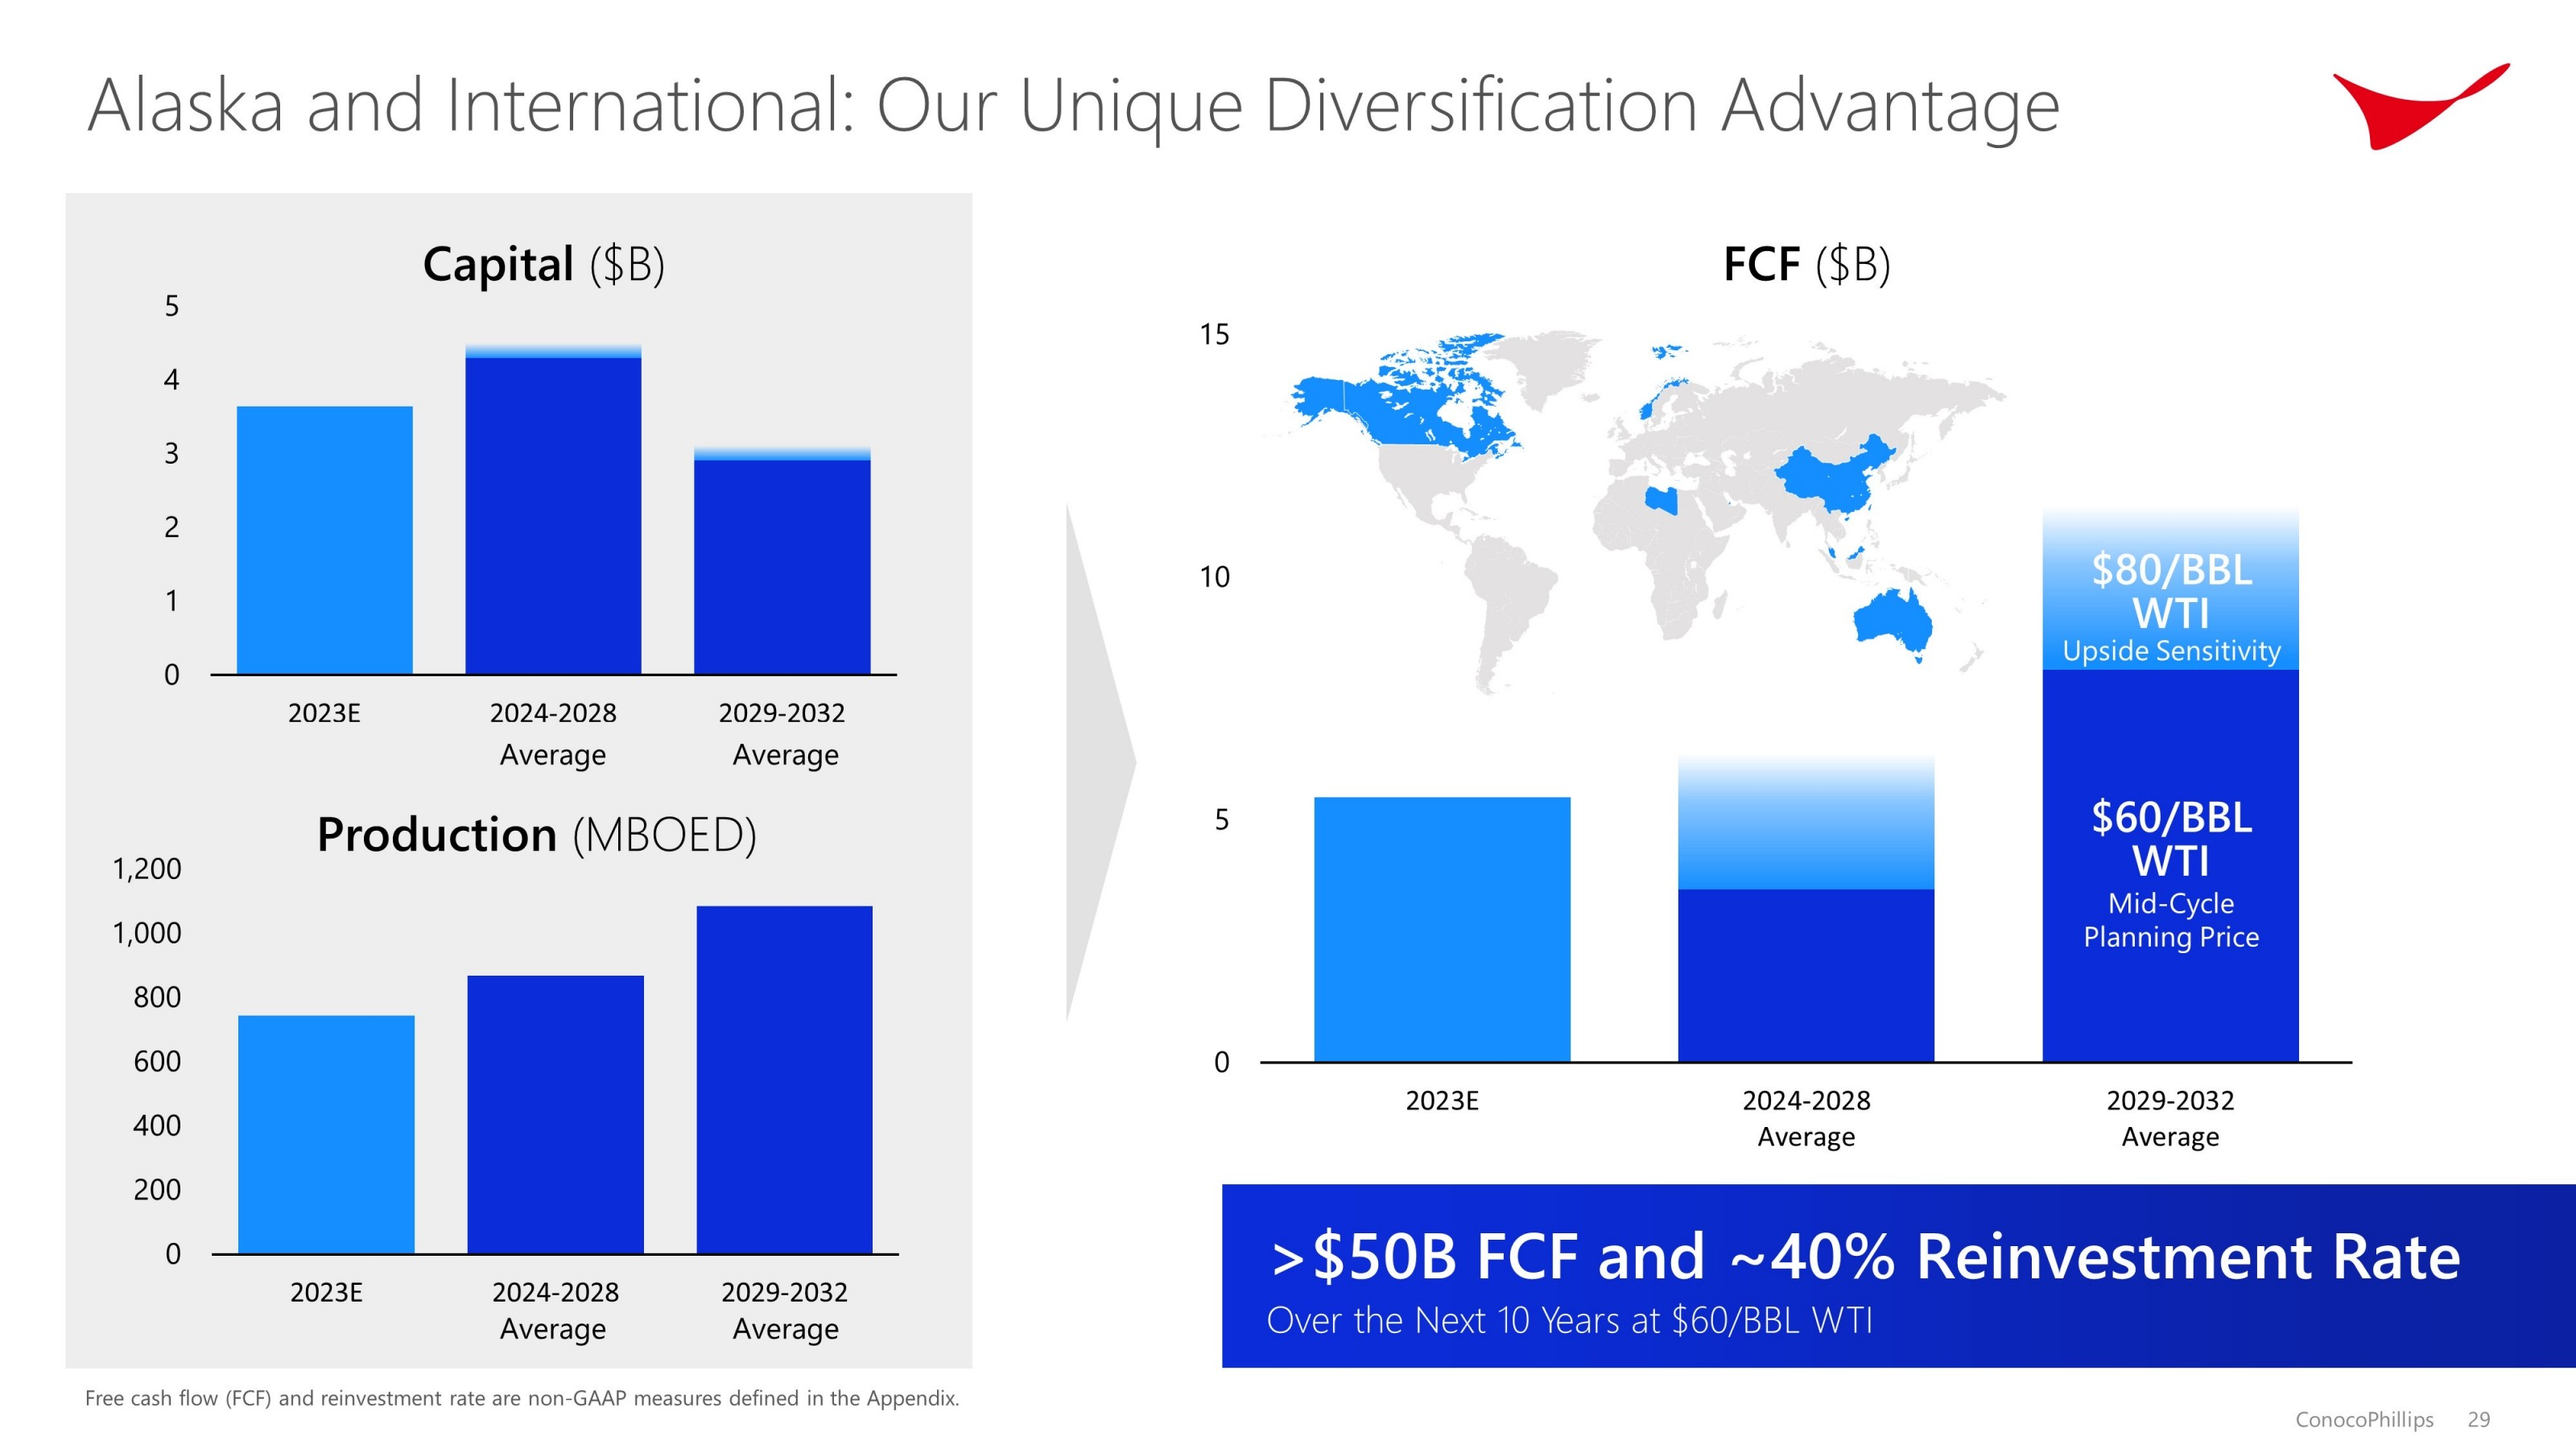

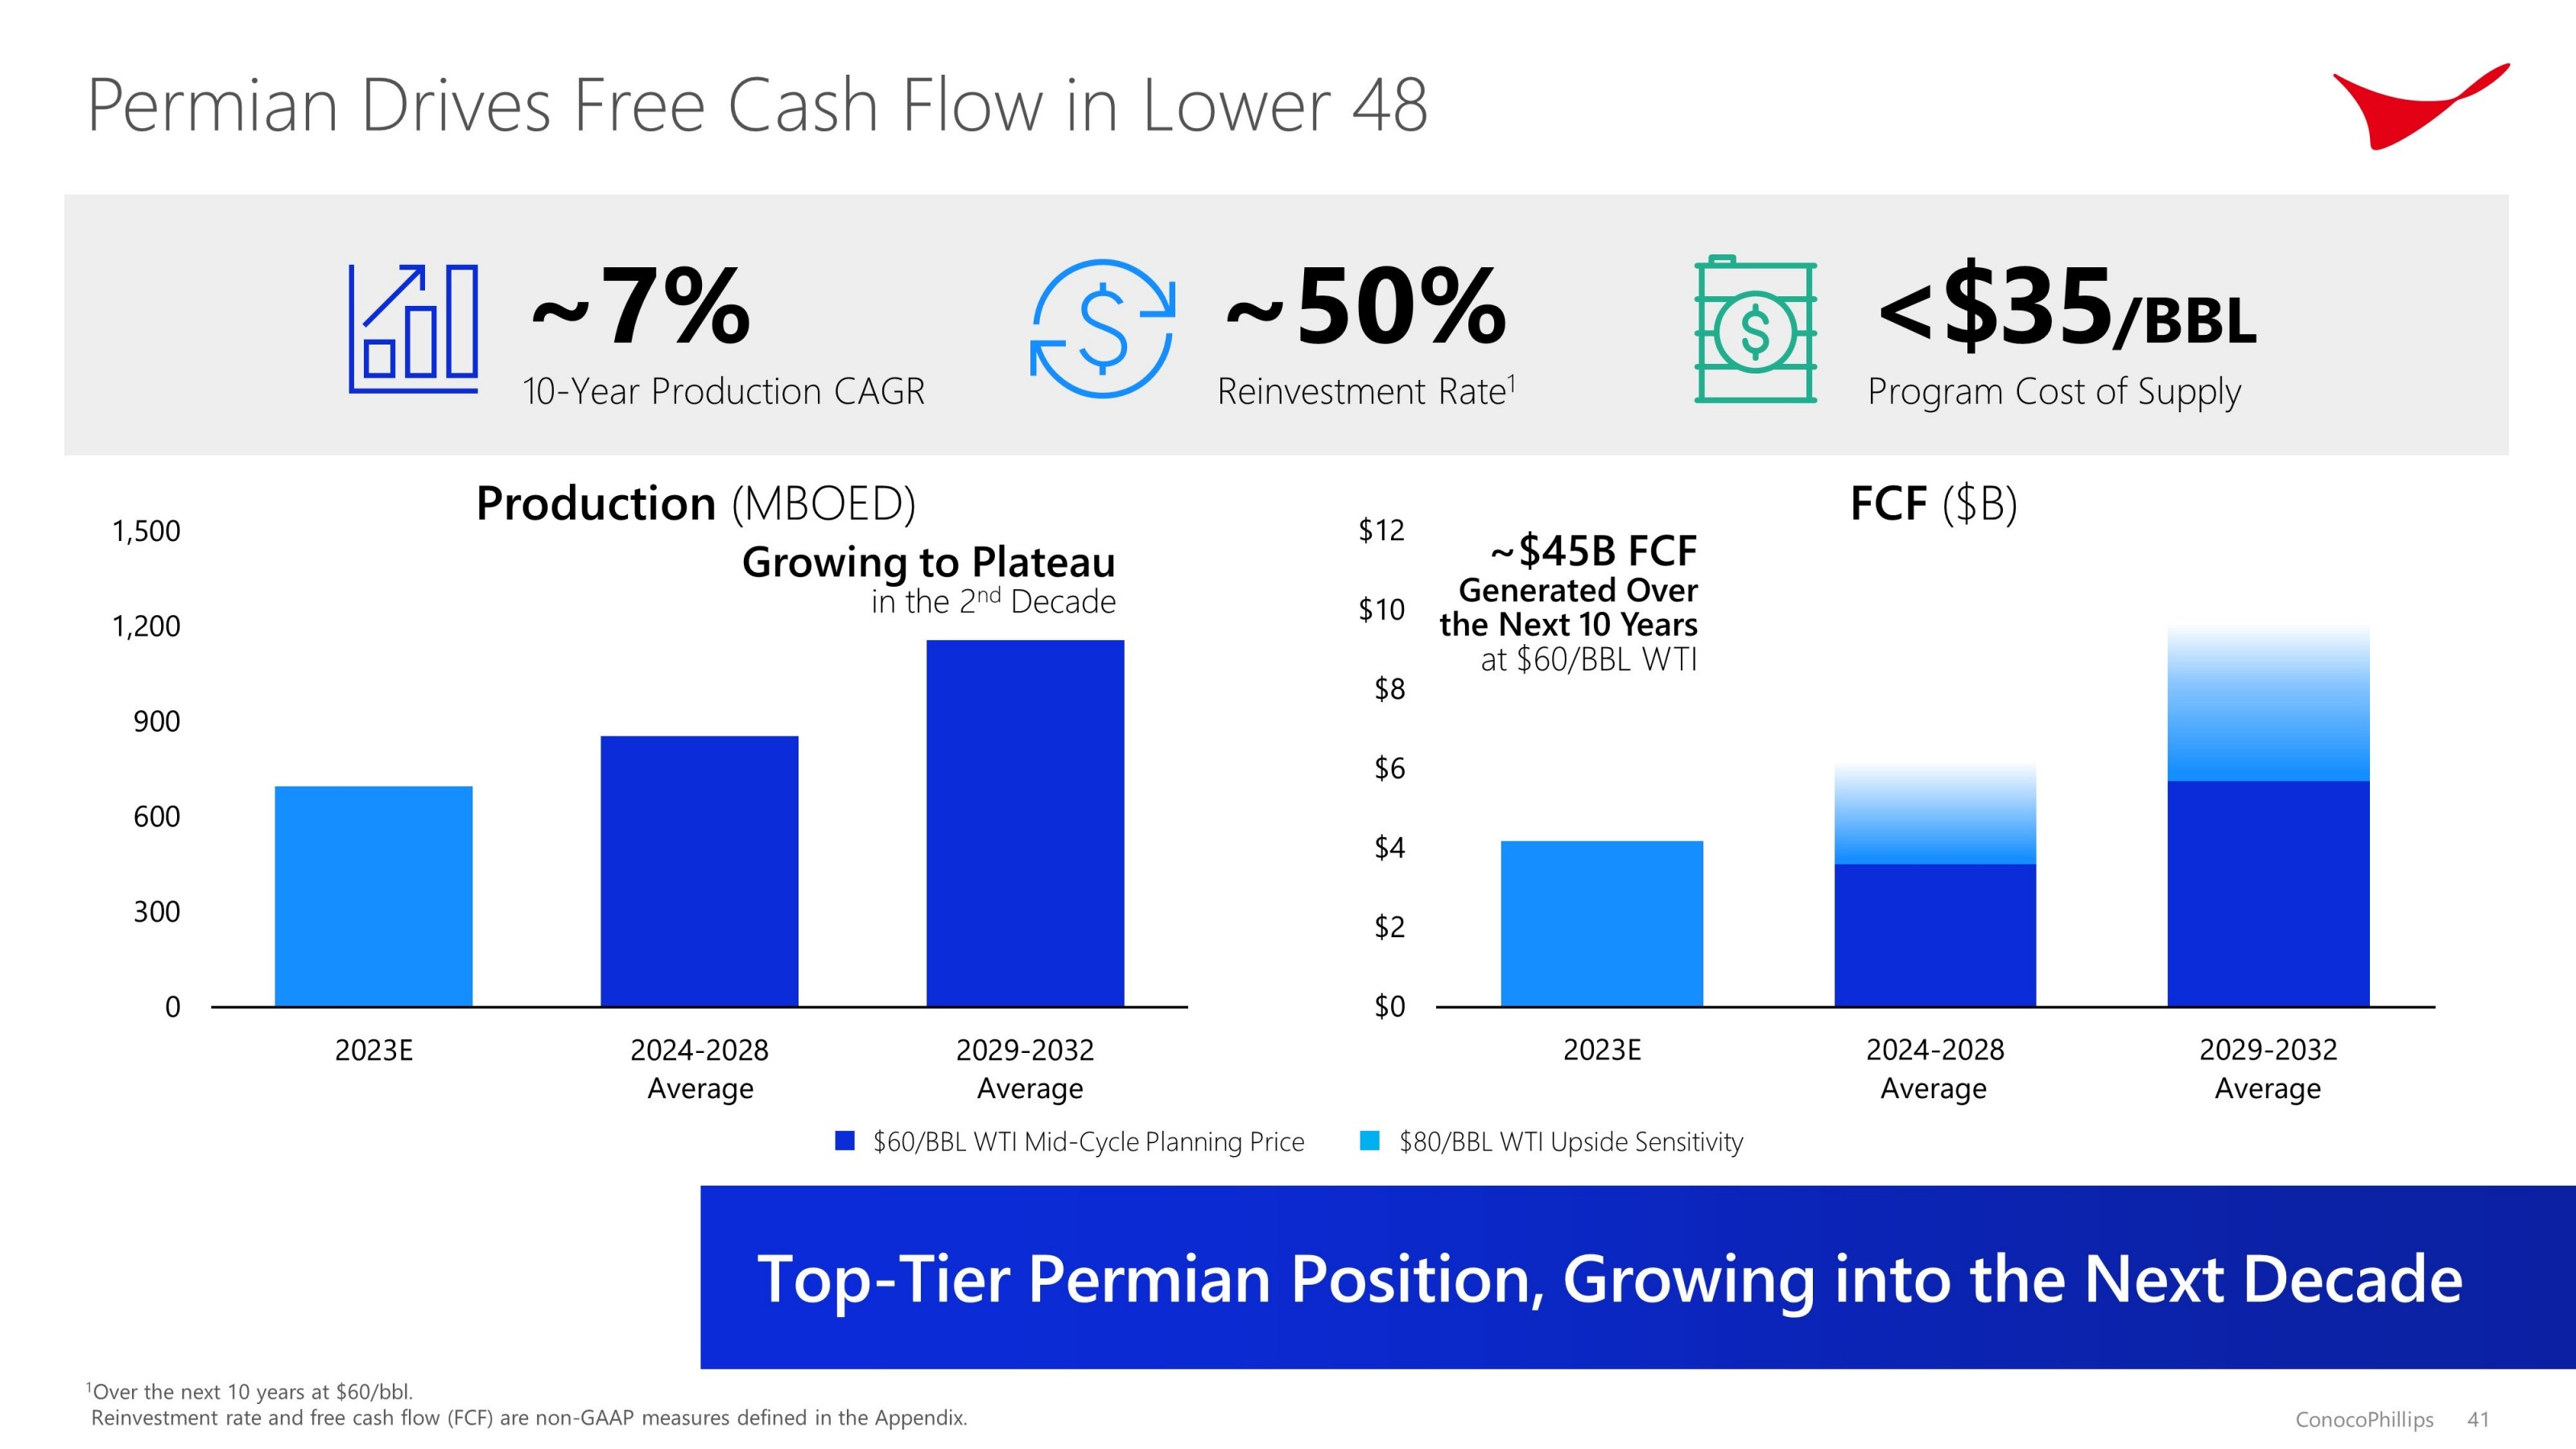

In [ ]:
response.response.render()

In [ ]:
response = query_engine.query(
    "Give me a summary of whether you think the financial projections are stable, and if not, what are the potential risk factors. "
    "Support your research with sources."
)

Summary assessment — Stability of the financial projections:
Overall: Moderately stable under the plan’s stated base-case assumptions (WTI ~ $60/bbl mid‑cycle). The company forecasts durable cash generation and improving returns—material free cash flow over the next 10 years, modest capital intensity for key longer‑cycle projects, and a strong balance sheet—which support the projections’ resilience. However, the projections are conditional: they assume specific commodity prices, execution of multi‑year projects, and limited downside from policy or macro shocks. If those assumptions hold, projections look stable; if not, downside risk increases materially.

Key supportive metrics cited (used to form this view):
- Projected free cash flow available for distribution: >$115B over next 10 years at $60/bbl WTI.
- CFO growth: ~6% CAGR (2024–2032) at $60/bbl WTI; FCF CAGR ~11% over same period.
- Net Debt / CFO: target ~0.3x (2024–2028 average) and lower by 2029–2032 in plan.
- Distribution framework: aim for ≥30% of CFO distributed, with multiple distribution channels (ordinary dividend, buybacks, VROC).
- Portfolio cost profile: large resource base with average Cost of Supply roughly in the low $30s/bbl WTI and substantial resource under <$40/bbl CoS.
These elements support durability so long as the plan’s price, cost and execution assumptions hold.

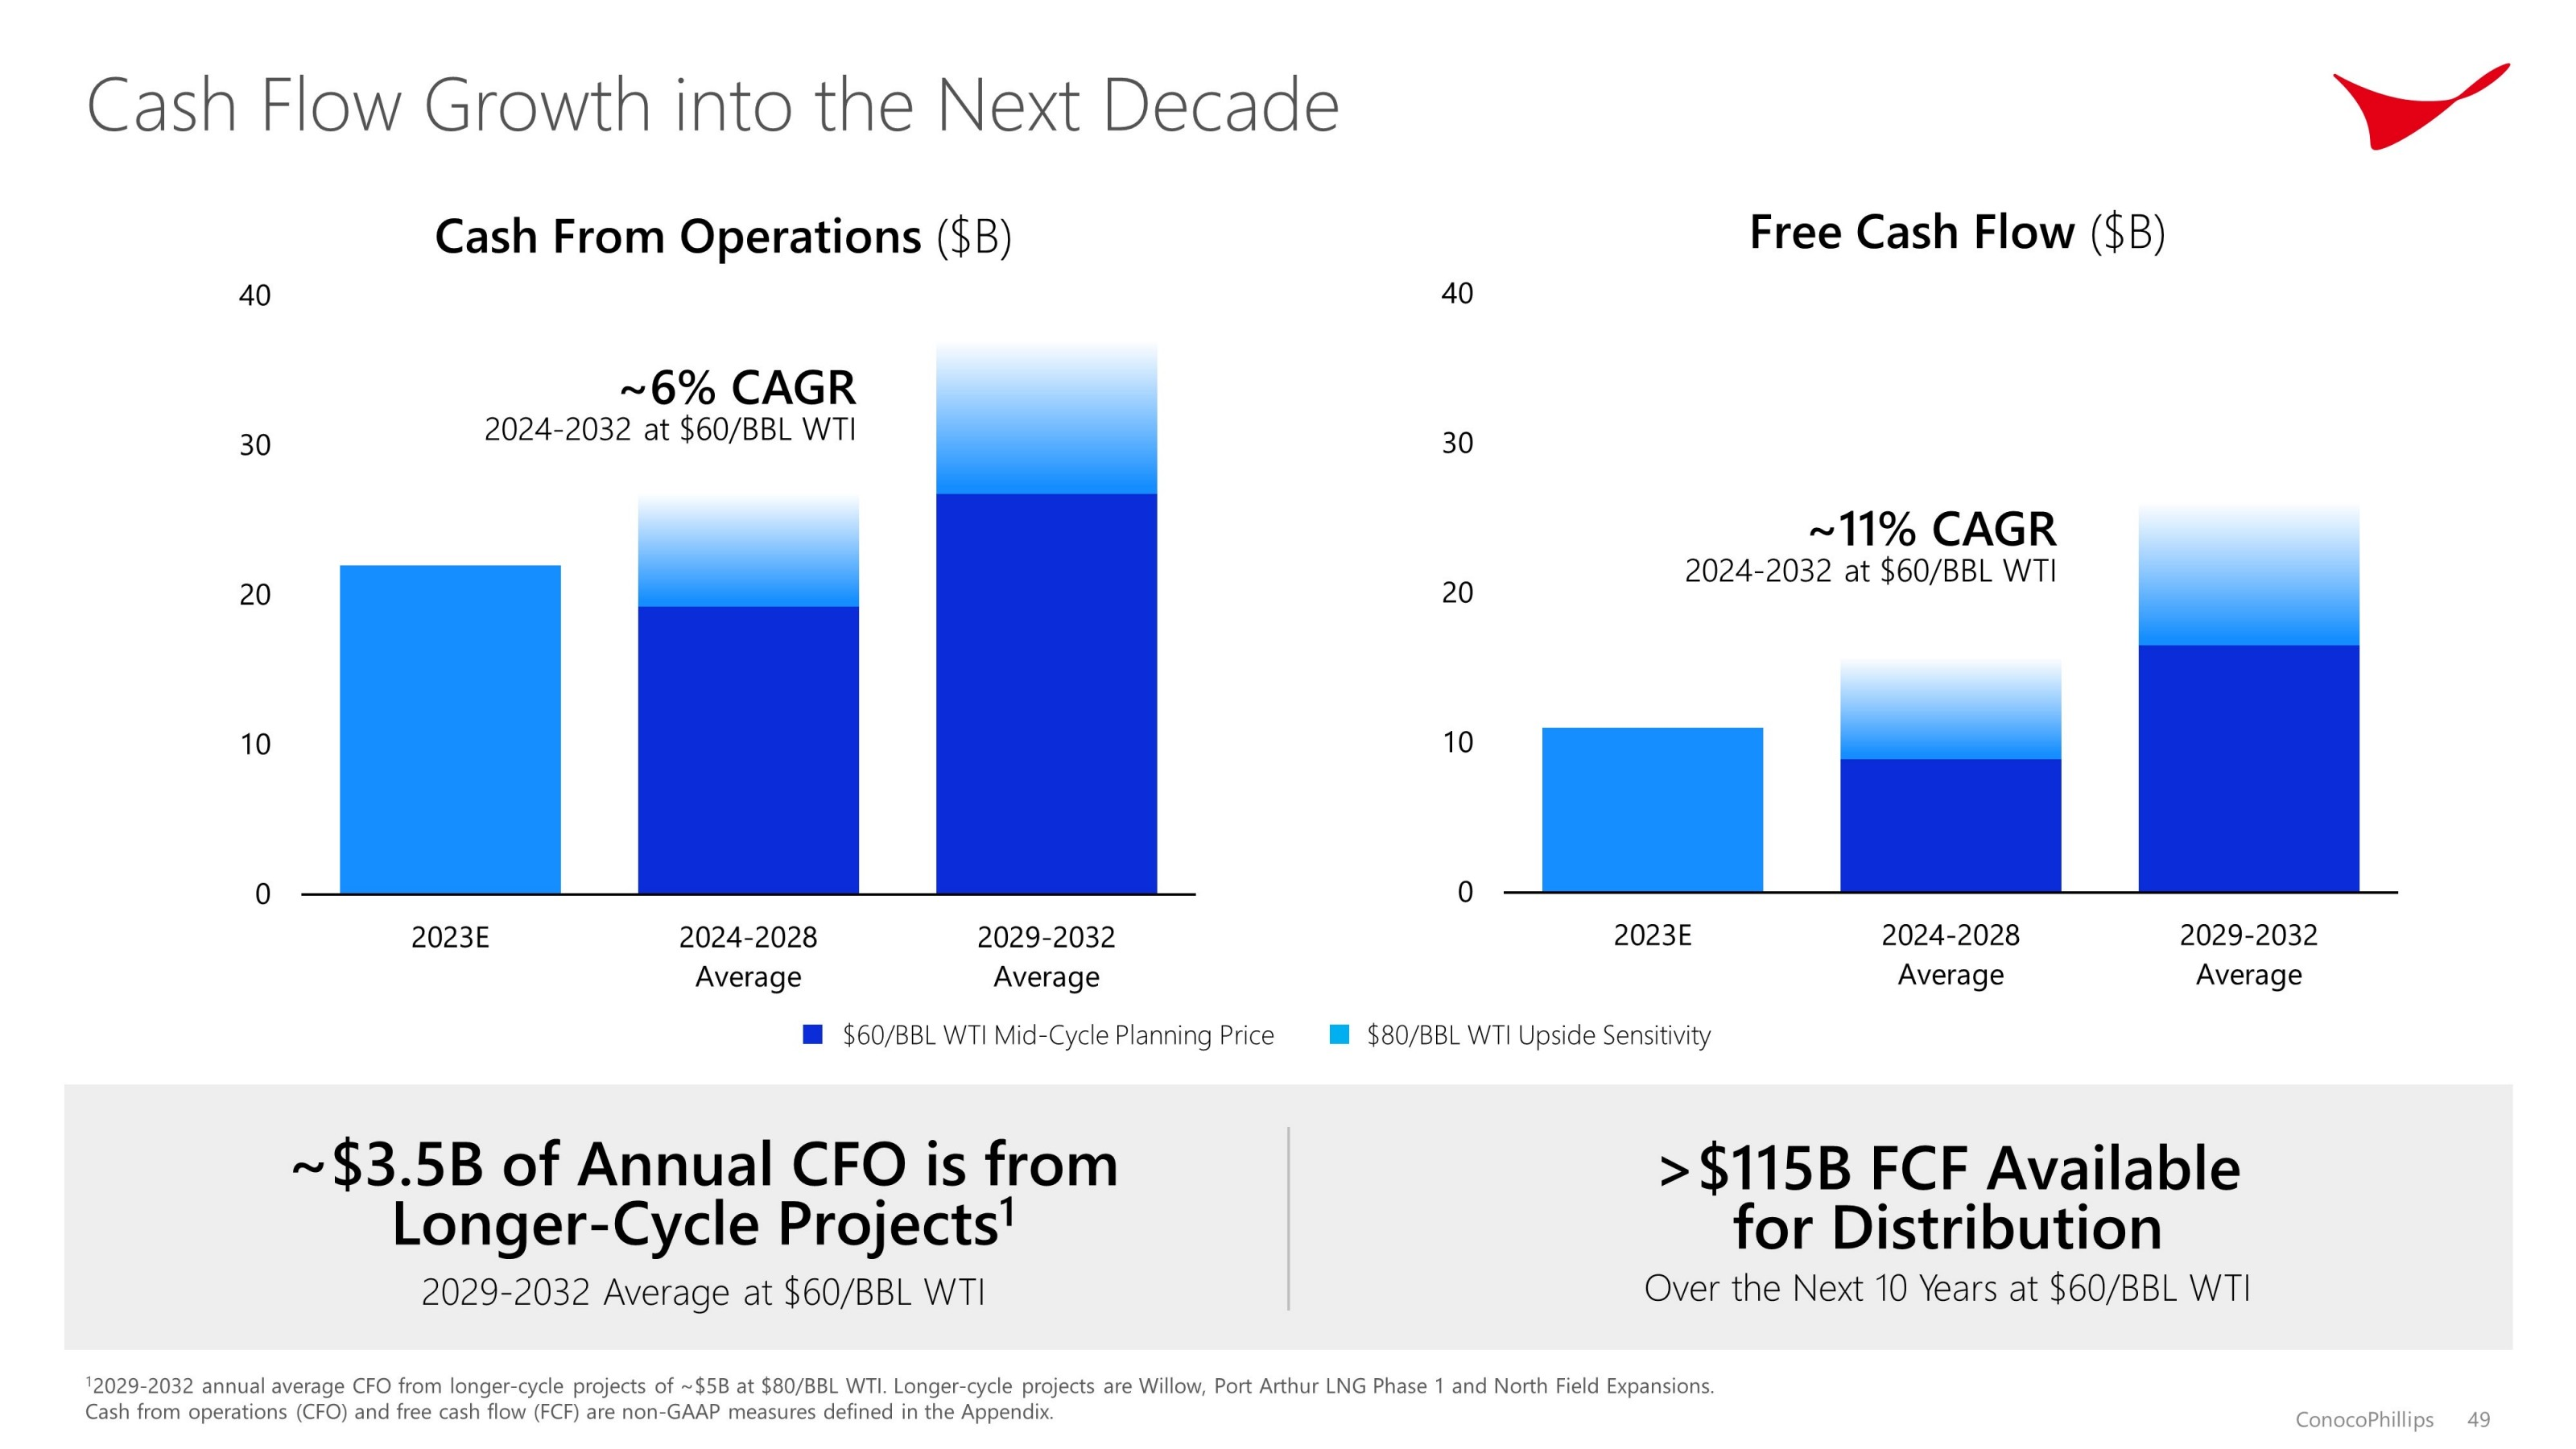

Principal downside risk factors (explicit in the plan and materially relevant):
1) Commodity price risk — The plan assumes a mid‑cycle WTI price (base case ~ $60/bbl). Significant, sustained price weakness versus this assumption reduces CFO/FCF, increases leverage ratios and can force lower distributions or higher borrowing.  
2) Execution risk on longer‑cycle projects — Delays or cost overruns on larger projects (e.g., multi‑year LNG expansions and major developments) would compress returns and postpone cash flows.  
3) Cost inflation and supply chain risk — Higher capital or operating cost escalation (drilling, fabrication, labor, materials) would raise Cost of Supply and reduce margins.  
4) Regulatory and policy risk — New or increased carbon pricing, emissions regulation, or permitting delays could increase costs or restrict development scope.  
5) Market / demand risk for LNG and exports — Slower global LNG demand or regional price differentials that deteriorate margins would impact forecasted LNG cash flows.  
6) Geopolitical and macro shocks — Conflict, global economic downturn, sanctions, or energy market disruption can change price, access or operations.  
7) Operational & safety risks — Facility disruptions, production incidents, or prolonged outages reduce near‑term cash flow.  
8) Liquidity / capital allocation risk — If cash generation weakens, the ability to sustain buybacks/dividends and maintain an ‘A’ rated balance sheet could be constrained.

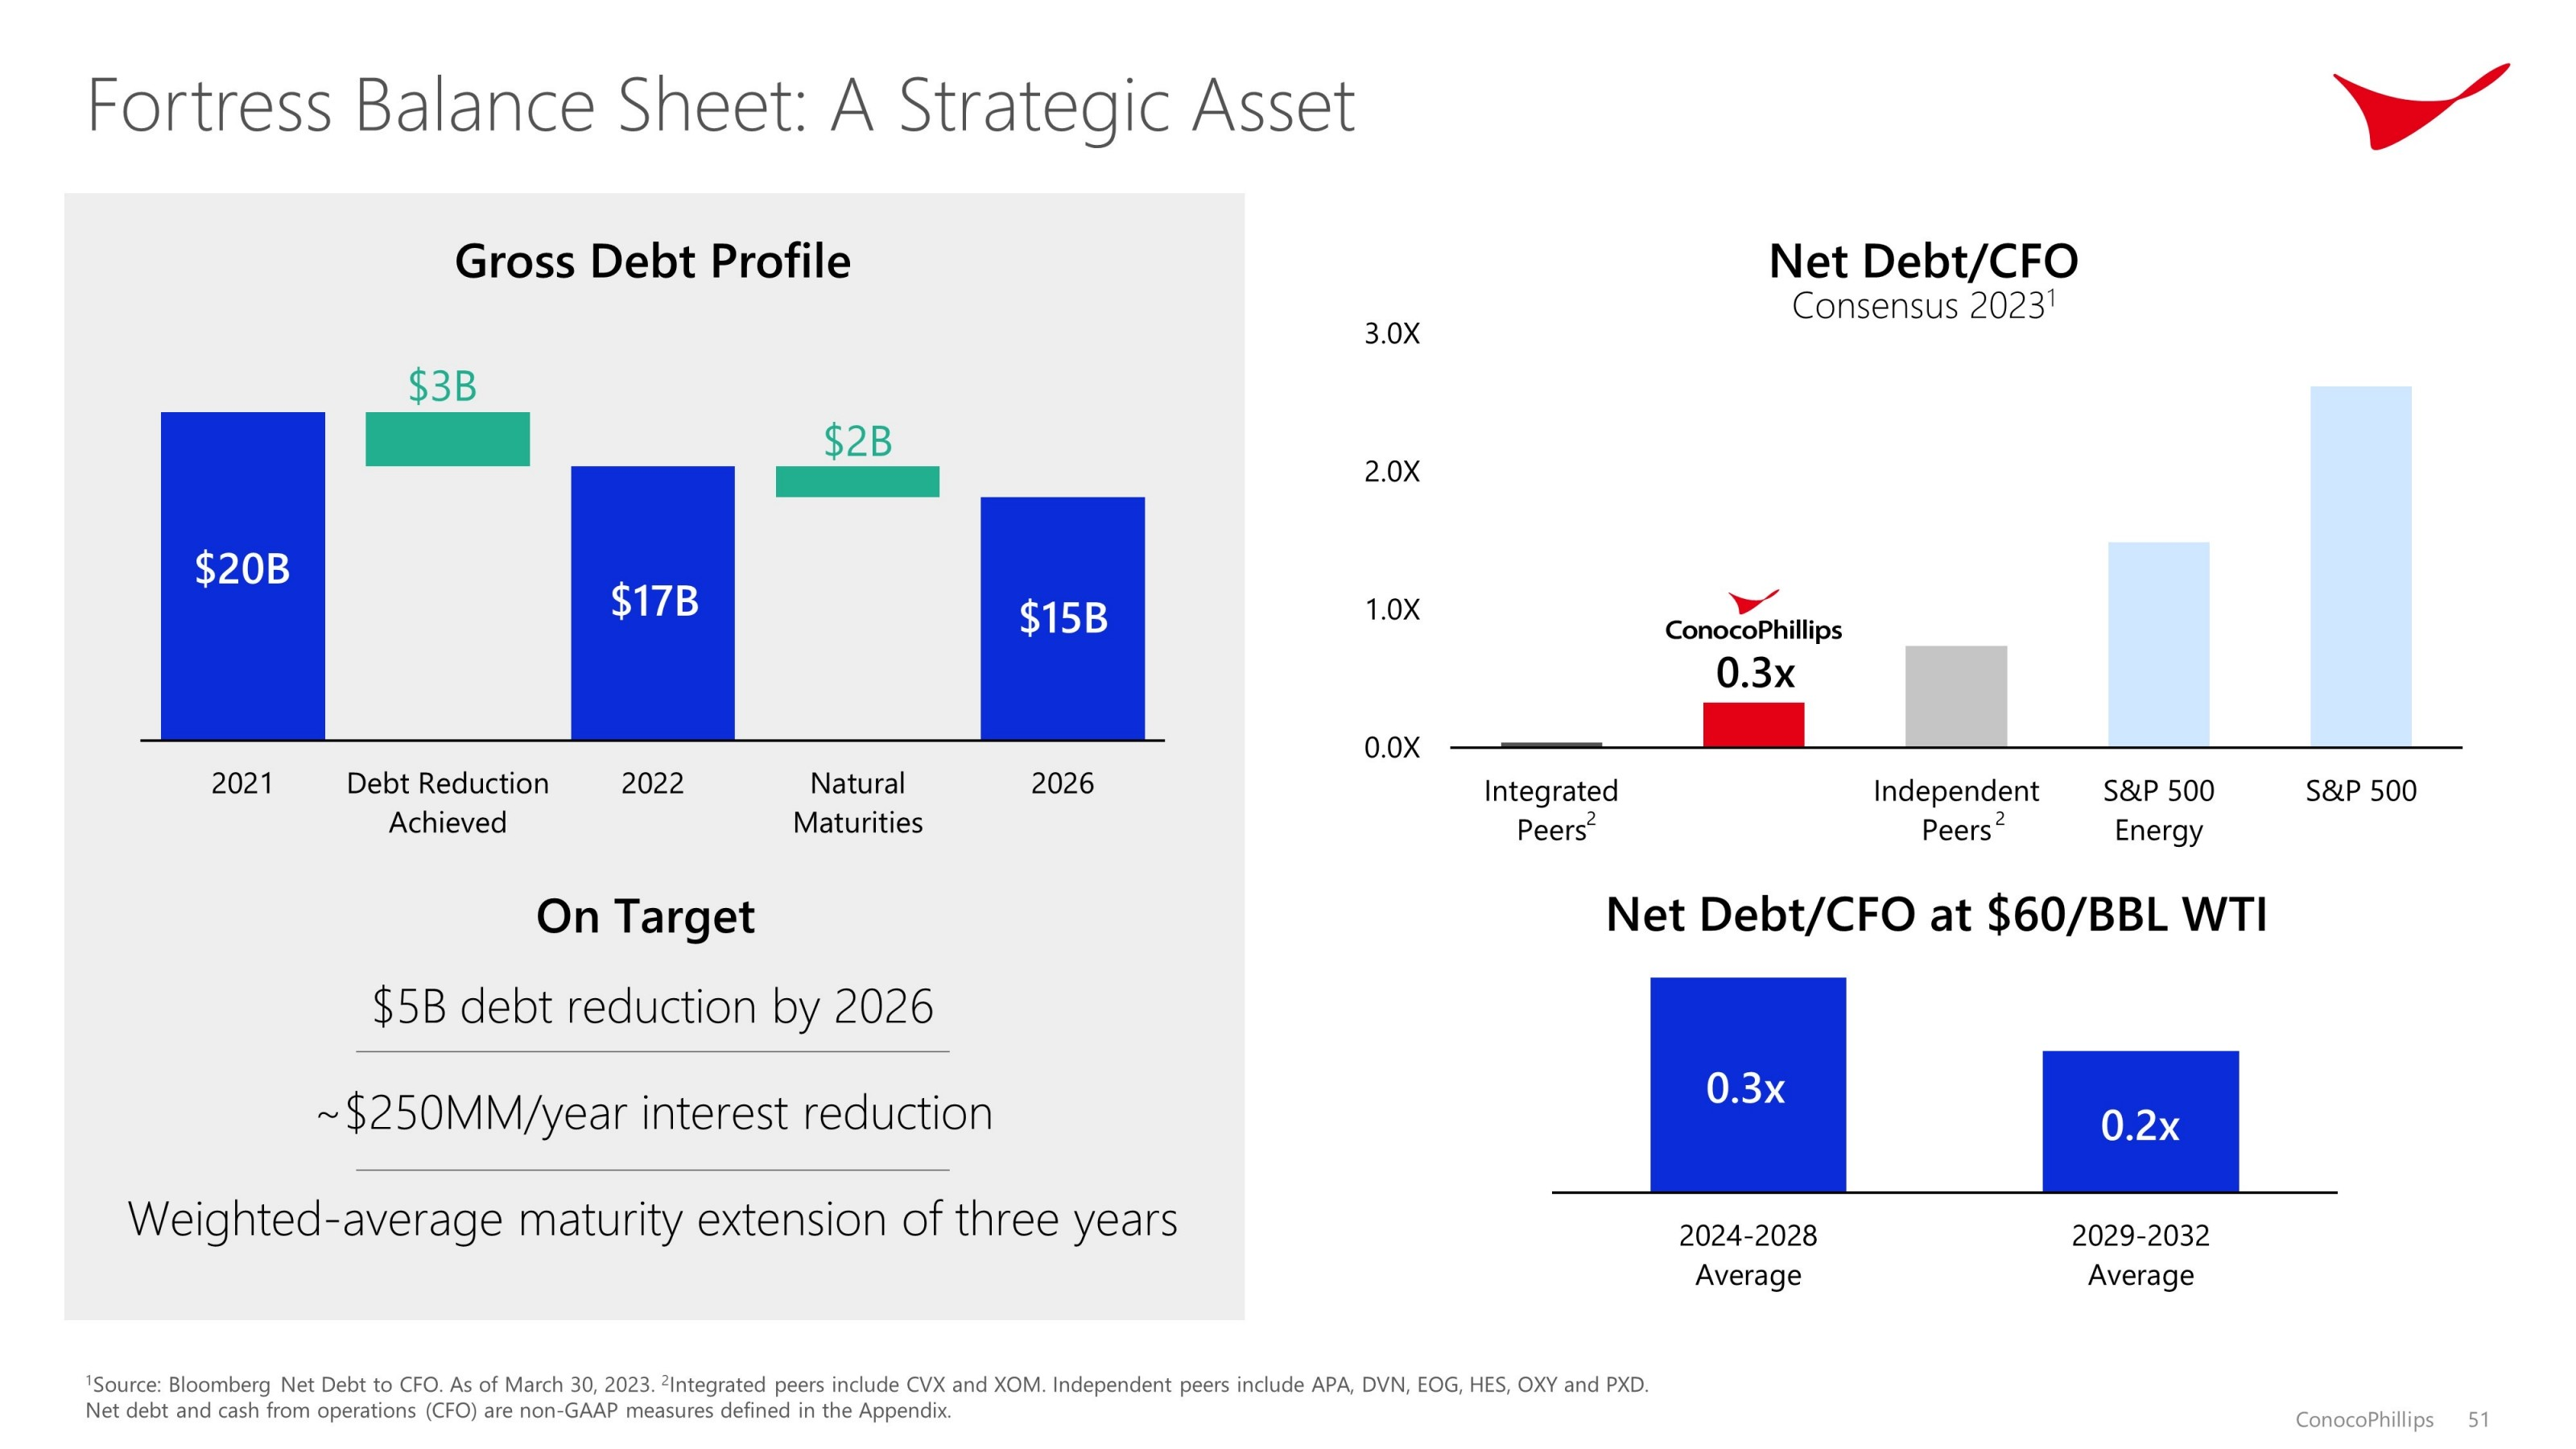

How the plan attempts to mitigate these risks (and remaining vulnerabilities):
- Mitigants: Low net leverage targets, explicit stress testing (two‑year $40/bbl scenario), holding strategic and reserve cash, disciplined reinvestment rate and Cost of Supply discipline, diversified portfolio (unconventional, conventional, LNG, international) that blends short‑cycle and longer‑cycle cash flows.  
- Remaining vulnerabilities: The plan is unhedged for price upside but also exposed to price downside; stress tests show resilience but sustained multi‑year weak prices or multiple simultaneous adverse factors (price + execution + regulatory) would still stress distributions and project timelines.

Practical takeaways / recommended monitoring items:
- Monitor realized WTI and regional gas/LNG pricing vs the $60 mid‑cycle assumption and the company’s $80 upside sensitivity.  
- Watch execution progress and cost performance on major projects (timing, capex to first oil/LNG) and any updates to capital guidance.  
- Track leverage metrics (Net Debt / CFO) and available cash levels to confirm balance‑sheet targets.  
- Watch regulatory developments (carbon pricing, flaring rules, permitting) and any announced changes to emissions targets or required investments.  

Sources: attached images provide the underlying cash‑flow, capital, and balance sheet charts used to form this assessment.

In [ ]:
response.response.render()